<a href="https://colab.research.google.com/github/Betson1/MachineLearning/blob/main/%D0%92%D1%82%D0%BE%D1%80%D0%B0%D1%8F_%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D1%87%D0%B0%D1%81%D1%82%D1%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт необходимых библиотек

In [ ]:
# Импортируем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Загрузка данных

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

auction = pd.read_csv('/content/drive/MyDrive/auction_verification.csv')

display(auction)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667
...,...,...,...,...,...,...,...,...,...
2038,2,3,2,1,90,5,0,True,82.425000
2039,2,3,2,1,90,5,1,True,1316.983333
2040,2,3,2,1,90,5,2,False,9365.450000
2041,2,3,2,1,90,5,3,False,8474.025000


# Анализ данных

In [ ]:
# размер датасета, 4424 записей, 37 столбцов

auction.shape


(2043, 9)

In [ ]:
auction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


In [ ]:
auction.describe()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.time
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,1.000000,2.093979,1.883994,0.587861,71.473324,3.252080,0.455213,7336.944574
std,0.816696,0.811269,0.320310,0.492340,8.048740,1.804225,1.062828,10375.393650
min,0.000000,0.000000,1.000000,0.000000,59.000000,1.000000,0.000000,77.916667
25%,0.000000,1.000000,2.000000,0.000000,65.000000,2.000000,0.000000,546.818910
50%,1.000000,2.000000,2.000000,1.000000,70.000000,3.000000,0.000000,1316.983333
75%,2.000000,3.000000,2.000000,1.000000,78.000000,5.000000,0.000000,10876.638889
max,2.000000,3.000000,2.000000,1.000000,90.000000,6.000000,4.000000,44130.520833


In [ ]:
auction['verification.result'].unique()

array([False,  True])

In [ ]:
# Теперь проверим количество строк, которое принадлежит каждому классу:

auction['verification.result'].value_counts()

,count
verification.result,
False,1781
True,262


Делаем балансировку для улучшения классификации

In [ ]:
from sklearn.utils import resample


# 1. Разделяем данные по классам
false = auction[auction['verification.result'] == False]
true = auction[auction['verification.result'] == True]


# 2. Определяем максимальное количество образцов среди классов (false)
max_count = false.shape[0]  # 2209

# 3. Выполняем oversampling для класса 'True'
true_oversampled = resample(
    true,
    replace=True,            # Разрешаем повторное использование образцов
    n_samples=max_count,     # Количество образцов после балансировки
    random_state=42          # Фиксируем случайное состояние для воспроизводимости
)

# 4. Объединяем сбалансированные классы с оригинальным классом 'false'
balanced_auction = pd.concat([false, true_oversampled])

# 5. Перемешиваем данные для обеспечения случайности
balanced_auction = balanced_auction.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверяем распределение классов после балансировки
print(balanced_auction['verification.result'].value_counts())

verification.result
True     1781
False    1781
Name: count, dtype: int64


# Визуализация данных

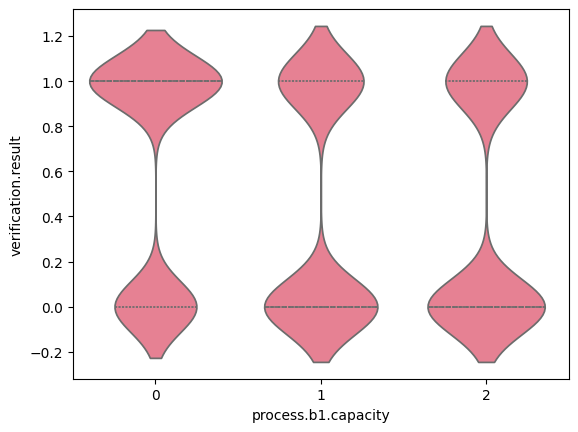

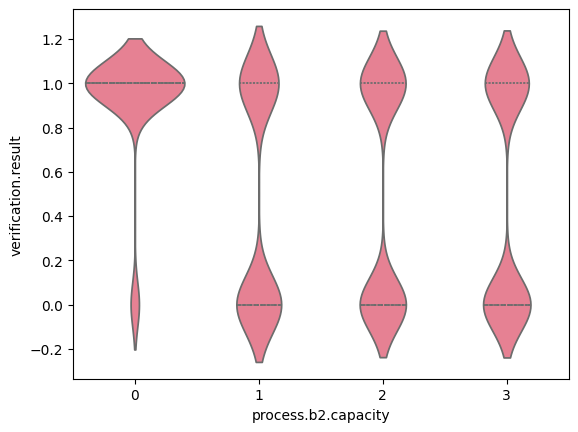

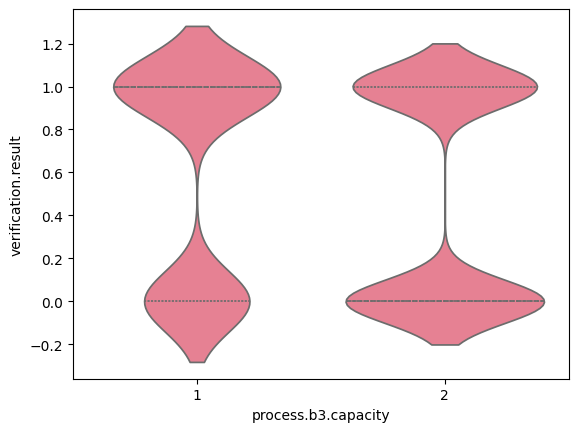

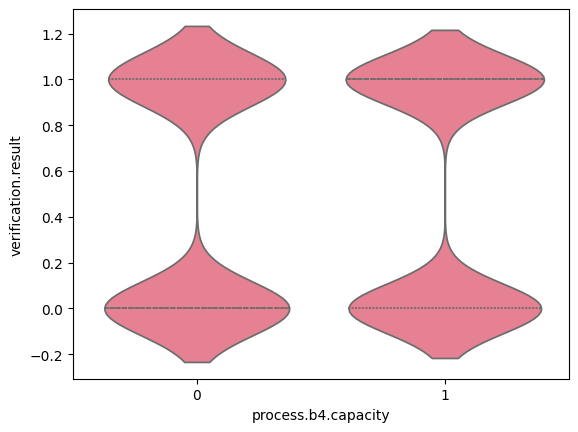

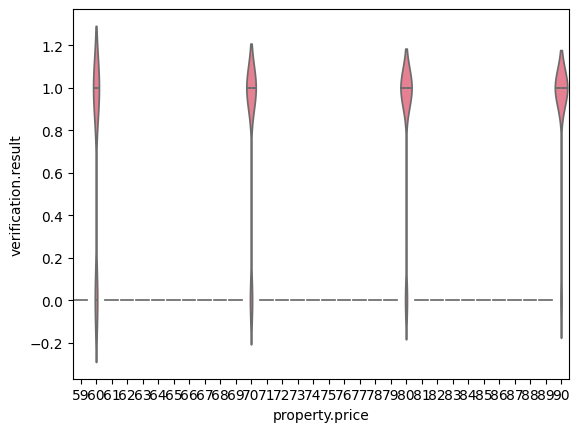

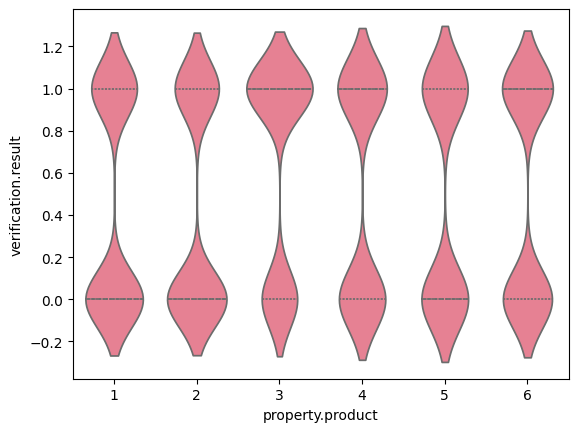

In [ ]:
# Скрипичный график.
# Используется для проверки сравнения распределения переменных:

sns.violinplot(y='verification.result', x='process.b1.capacity', data=balanced_auction, inner='quartile')
plt.show()
sns.violinplot(y='verification.result', x='process.b2.capacity', data=balanced_auction, inner='quartile')
plt.show()
sns.violinplot(y='verification.result', x='process.b3.capacity', data=balanced_auction, inner='quartile')
plt.show()
sns.violinplot(y='verification.result', x='process.b4.capacity', data=balanced_auction, inner='quartile')
plt.show()
sns.violinplot(y='verification.result', x='property.price', data=balanced_auction, inner='quartile')
plt.show()
sns.violinplot(y='verification.result', x='property.product', data=balanced_auction, inner='quartile')
plt.show()

<Figure size 800x640 with 0 Axes>

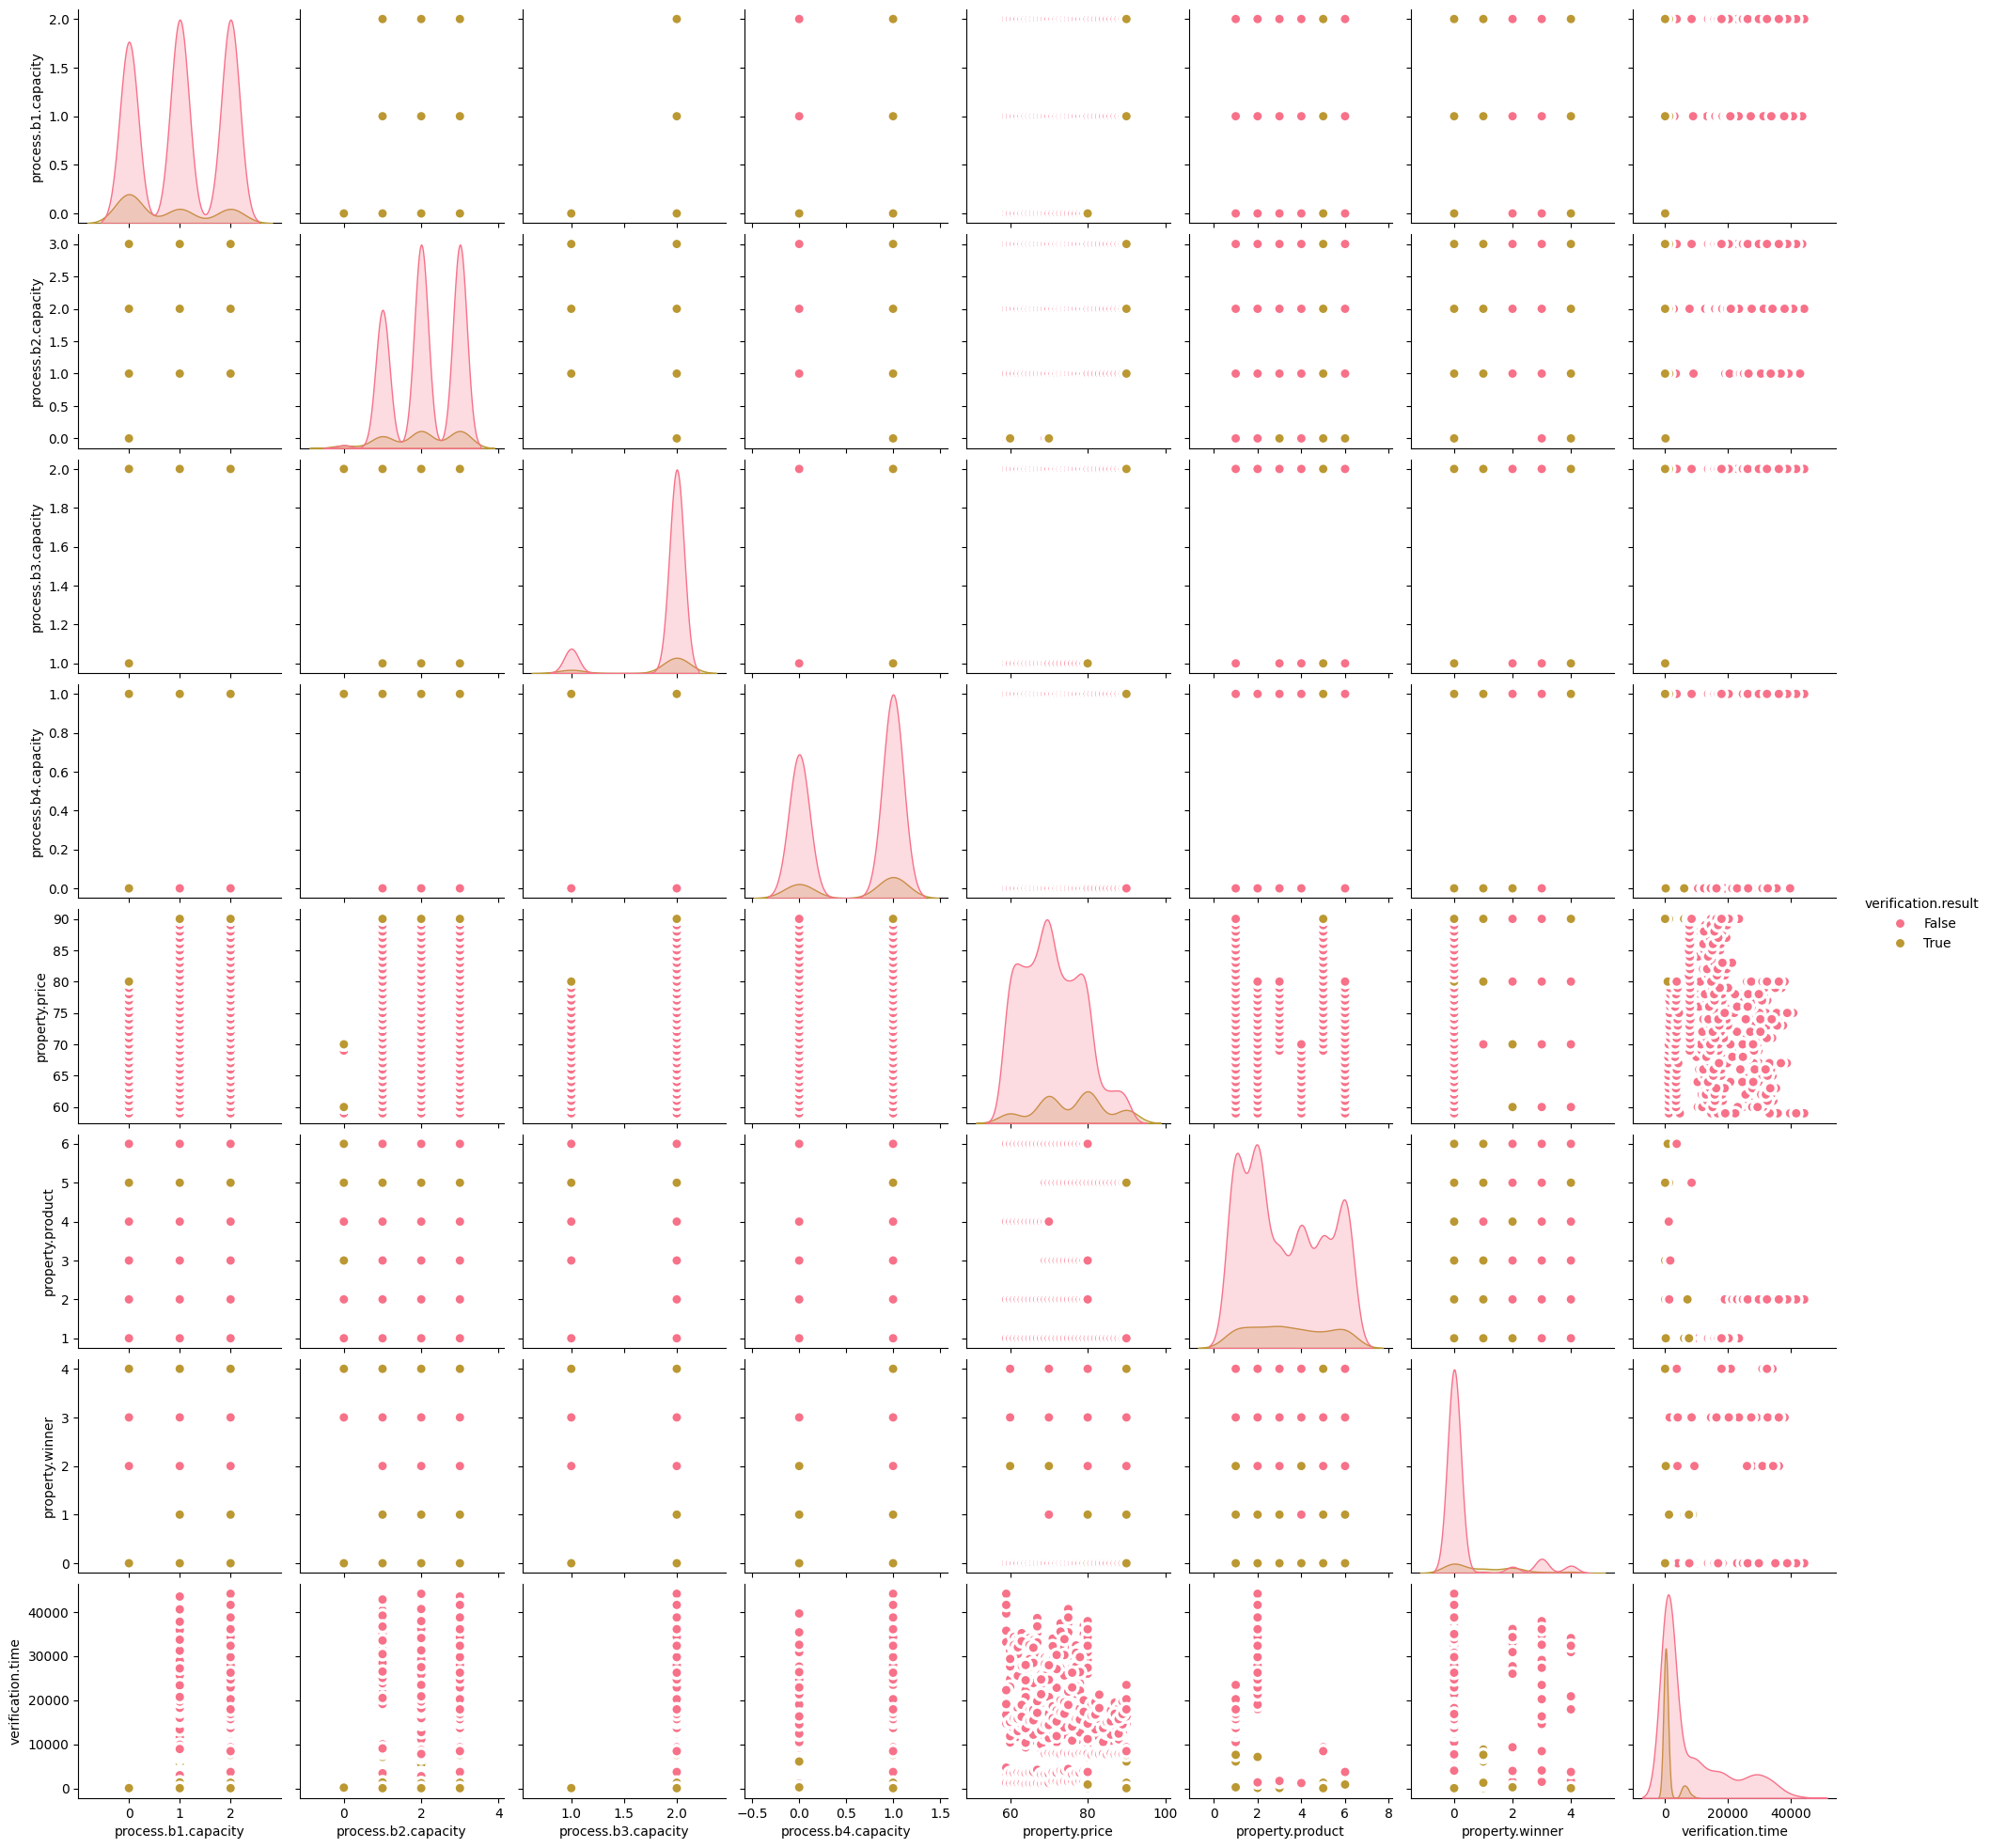

In [ ]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(auction, kind="scatter", hue="verification.result", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

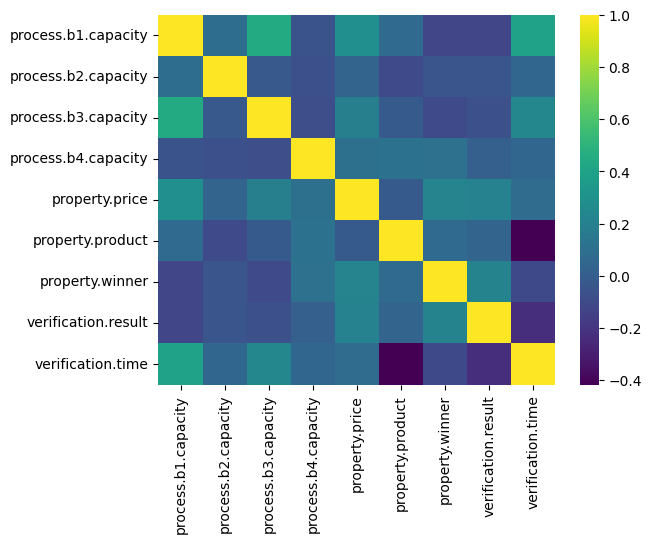

In [ ]:
# Вычисляем матрицу корреляции только для числовых столбцов
corr_matrix = auction.corr(numeric_only=True)
# Пример 2: Строим тепловую карту корреляции
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.show()

# Построение модели

Y - целевая переменная, которую предсказываем. Мы ищем зависимость этой переменной от соответствующих фич. В нашем случае это столбец verification.result.

В X складываем весь набор данных без целевой переменной.

In [ ]:
X = balanced_auction.drop(['verification.result'], axis=1)
y = balanced_auction['verification.result']
print(f'X shape: {X.shape} | y shape: {y.shape} ')

X shape: (3562, 8) | y shape: (3562,) 


## Train Test разделение

Разделяем наш набор данных на обучающий (train) и тестовый (test) с помощью train_test_split(), мы берем 80% данных для обучения нашей модели и 20% оставляем в качестве проверочного набора данных:

In [ ]:
import scipy.stats as stats

y_mapped = y.map({False: 0, True: 1,})

X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.20, random_state=15, stratify=y_mapped)

stats.ttest_ind (a=y_train, b=y_test)

TtestResult(statistic=0.04186336327527753, pvalue=0.9666099702756814, df=3560.0)

## Обучение и выбор оптимальной модели

Далее попробуем следующие алгоритмы:

Logistic Regression (LR) </br>
Linear Discriminant Analysis (LDA)</br>
K-Nearest Neighbors (KNN)</br>
Classification and Regression Trees (CART)</br>
Gaussian Naive Bayes (NB)</br>
Support Vector Machines (SVM)</br>

In [ ]:
# создаем лист для тех моделей, которые будем изучать
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# оцениваем их метрики
results = []
model_names = []
for name, model in models:
  kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  model_names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LR: 0.756752 (0.010412)
LDA: 0.768684 (0.012724)
KNN: 0.952261 (0.009328)
CART: 0.997193 (0.004092)
NB: 0.655670 (0.021919)
SVM: 0.996489 (0.003511)


K-Nearest Neighbors (KNN), Classification and Regression Trees (CART) и Support Vector Machines (SVM) классификаторы показали лучшие метрики среди всех алгоритмов.
Далее работаем с KNN.

Давайте обучим модель KNN на нашем обучающем наборе и сделаем прогноз на тестовом наборе на следующем шаге.

## Обучение конкретной модели
Определяем нашу модель KNN
После этого подгоняем/обучаем модель на X_train и Y_train с помощью метода .fit().
Затем мы делаем прогноз на X_test с помощью метода .predict().

In [ ]:
sk_lda = KNeighborsClassifier()
sk_lda.fit(X_train, y_train)
sk_lda_pred_res = sk_lda.predict(X_test)
#sk_transformed = sk_lda.transform(X_train)
sk_lda_accuracy = accuracy_score(y_test, sk_lda_pred_res)

print(f'sk LDA accuracy: {sk_lda_accuracy}')
print(f'sk LDA prediction: {sk_lda_pred_res}')
#print('sk transformed features', sk_transformed[:5].T, sep='\n')

sk LDA accuracy: 0.9551192145862553
sk LDA prediction: [1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1
 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1
 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1
 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1
 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1
 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1
 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0
 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0
 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1
 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 

## Визуализация решения

<Axes: title={'center': 'LDA surface with original features'}>

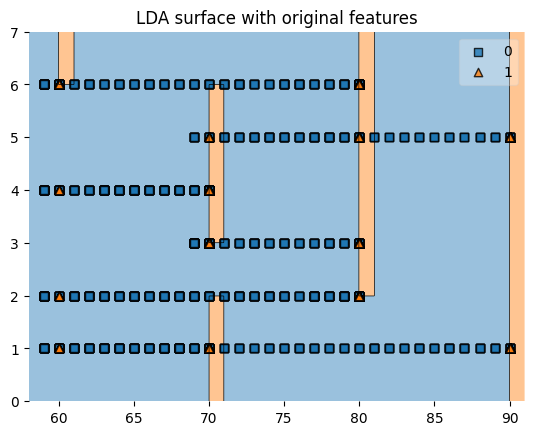

In [ ]:
from mlxtend.plotting import plot_decision_regions

# Создадим целевой вектор y_2d
# Преобразуем классы к классам 0, 1, 2 соответственно
#y_s = y_train.map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
y_s = y_train
X_2d= X_train[['property.price', 'property.product']].values

y_2d = y_s.values


sk_lda1 = DecisionTreeClassifier()
sk_lda1.fit(X_2d, y_2d)

plt.title('LDA surface with original features')
plot_decision_regions(
    	X=X_2d,
    	y=y_2d,
    	clf=sk_lda1)

Accuracy: 0.85
Recall (weighted): 0.85
Precision (weighted): 0.85
Detail:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       534
           1       0.41      0.46      0.43        79

    accuracy                           0.85       613
   macro avg       0.67      0.68      0.67       613
weighted avg       0.85      0.85      0.85       613



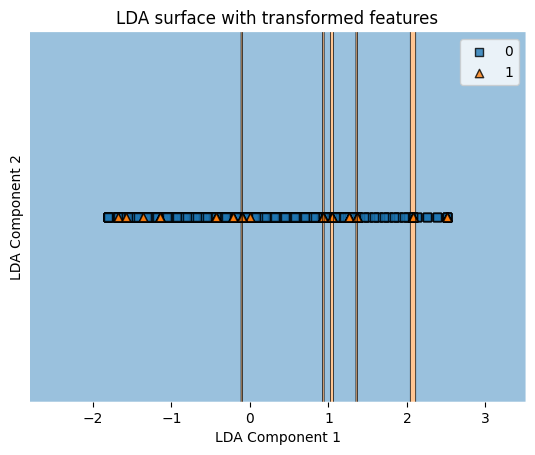

In [ ]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.metrics import roc_auc_score
df = auction["verification.result"].map({False: 0, True: 1})
ys = df.values

# Выбор признаков
Xs = auction[['property.price', 'property.product']]

# Инициализация LDA
lda = LinearDiscriminantAnalysis()

# Обучение и трансформация признаков
X1_lda = lda.fit_transform(Xs, ys)

# Разделение на обучающую и тестовую выборки
X1_lda_train, X1_lda_test, y1_train, y1_test = train_test_split(X1_lda, ys, random_state=0, test_size=0.3)

# Инициализация и обучение дерева решений
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X1_lda_train, y1_train)

# Предсказание на тестовом наборе
predicted = decision_tree.predict(X1_lda_test)

# Оценка метрик
accuracy = metrics.accuracy_score(y1_test, predicted)
recall = metrics.recall_score(y1_test, predicted, average="weighted")
precision = metrics.precision_score(y1_test, predicted, average="weighted")

print(f"Accuracy: {round(accuracy, 2)}")
print(f"Recall (weighted): {round(recall, 2)}")
print(f"Precision (weighted): {round(precision, 2)}")

# Изменение: выбор вероятностей для положительного класса (класс 1)
predicted_proba_positive_class = predicted_proba[:, 1]

# Расчёт AUC (требуется вероятности для каждого класса)
auc = roc_auc_score(y1_test, predicted_proba_positive_class, multi_class='ovr')
# if hasattr(decision_tree, "predict_proba"):
#     predicted_proba = decision_tree.predict_proba(X1_lda_test)
#     auc = roc_auc_score(y1_test, predicted_proba, multi_class='ovr')
#     print(f"AUC: {round(auc, 2)}")
# else:
#     print("Модель не поддерживает predict_proba, поэтому AUC не может быть рассчитан.")

# Отчёт классификации
print("Detail:")
print(metrics.classification_report(y1_test, predicted, target_names=[str(i) for i in np.unique(y1_test)]))

# Визуализация границ принятия решений
plt.title('LDA surface with transformed features')
plot_decision_regions(X=X1_lda, y=ys, clf=decision_tree)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(loc='upper right')
plt.show()